# Importing Necessary Libraries

In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split as tts , RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('train.csv') #read the train data

In [3]:
train_df.head() #checking the first five values from dataset

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529544,High_spent_Small_value_payments,312.4940887,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.2802216,Low_spent_Large_value_payments,284.6291625,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.69952126,Low_spent_Medium_value_payments,331.2098629,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580744,Low_spent_Small_value_payments,223.4513097,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.42015309,High_spent_Medium_value_payments,341.489231,Good


# Modifying the dataset

# Annual_Income Update

In [4]:
# Update/Remove garbage values in the 'Annual_Income' column 
train_df['Annual_Income'] = train_df['Annual_Income'].str.rstrip('_')

In [5]:
# Convert 'Annual_Income' column to float
train_df['Annual_Income'] = train_df['Annual_Income'].astype(float)

# Monthly_Inhand_Salary update

In [6]:
most_common_Monthly_Inhand_Salary = train_df.groupby('Customer_ID')['Monthly_Inhand_Salary'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Monthly_Inhand_Salary'] = train_df['Customer_ID'].map(most_common_Monthly_Inhand_Salary)



# Num_Bank_Accounts update

In [7]:
def replace_Num_Bank_Accounts(x):
    zero = 0
    value_counts = x.value_counts()
    if 0 in value_counts:
        value_counts = value_counts.drop(0)
        if not value_counts.empty:
            return value_counts.idxmax()
        else:
            return zero
    else:
        return value_counts.idxmax()

In [8]:
most_common_Num_Bank_Accounts = train_df.groupby('Customer_ID')['Num_Bank_Accounts'].apply(replace_Num_Bank_Accounts)

# Map the most common values back to the original DataFrame
train_df['Num_Bank_Accounts'] = train_df['Customer_ID'].map(most_common_Num_Bank_Accounts)

# Remove the rows have Num_Bank_Accounts = 0
train_df = train_df[train_df['Num_Bank_Accounts'] != 0]

# Num_Credit_Card update

In [9]:
most_common_num_credit_card = train_df.groupby('Customer_ID')['Num_Credit_Card'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Num_Credit_Card'] = train_df['Customer_ID'].map(most_common_num_credit_card)


# Interest_Rate update

In [10]:
most_common_Interest_Rate = train_df.groupby('Customer_ID')['Interest_Rate'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Interest_Rate'] = train_df['Customer_ID'].map(most_common_Interest_Rate)

# Num_of_Loan update

In [11]:
# Update/Remove garbage values in the 'Num_of_Loan' column 
train_df['Num_of_Loan'] = train_df['Num_of_Loan'].str.rstrip('_')

# Update'Num_of_Loan' column to int type
train_df['Num_of_Loan'] = train_df['Num_of_Loan'].astype(int)

In [12]:
most_common_Num_of_Loan = train_df.groupby('Customer_ID')['Num_of_Loan'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Num_of_Loan'] = train_df['Customer_ID'].map(most_common_Num_of_Loan)


# Type_of_Loan update

In [13]:
# Fill null values in the 'Type_of_Loan' column with 'empty String'
train_df['Type_of_Loan'] = train_df['Type_of_Loan'].fillna('Not Specified')

most_common_Type_of_Loan = train_df.groupby('Customer_ID')['Type_of_Loan'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Type_of_Loan'] = train_df['Customer_ID'].map(most_common_Type_of_Loan)

# Delay_from_due_date update

In [14]:
# Update negative values in the 'Delay_from_due_date' column to 0
train_df.loc[train_df['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = 0


# Num_of_Delayed_Payment update

In [15]:
# Fill null values in the 'Num_of_Delayed_Payment' column with '0'
train_df['Num_of_Delayed_Payment'] = train_df['Num_of_Delayed_Payment'].fillna('0')

# Update/Remove garbage values in the 'Num_of_Delayed_Payment' column 
train_df['Num_of_Delayed_Payment'] = train_df['Num_of_Delayed_Payment'].str.rstrip('_')

# Update'Num_of_Delayed_Payment' column to int type
train_df['Num_of_Delayed_Payment'] = train_df['Num_of_Delayed_Payment'].astype(int)

# Update negative values of'Num_of_Delayed_Payment' column to 0
train_df.loc[train_df['Num_of_Delayed_Payment'] < 0, 'Num_of_Delayed_Payment'] = 0


# Changed_Credit_Limit update

In [16]:
#remove garbage value from 'Changed_Credit_Limit'
train_df['Changed_Credit_Limit'] = train_df['Changed_Credit_Limit'].replace('_','0')

#Update 'Changed_Credit_Limit' to float type
train_df['Changed_Credit_Limit'] = train_df['Changed_Credit_Limit'].astype(float)

#update negative values to 0
train_df.loc[train_df['Changed_Credit_Limit'] < 0, 'Changed_Credit_Limit'] = 0


# Num_Credit_Inquiries update

In [17]:
most_common_Num_Credit_Inquiries = train_df.groupby('Customer_ID')['Num_Credit_Inquiries'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Num_Credit_Inquiries'] = train_df['Customer_ID'].map(most_common_Num_Credit_Inquiries)


# Credit_Mix update

In [18]:
def replace_credit_mix(x):
    value_counts = x.value_counts()
    if '_' in value_counts:
        value_counts = value_counts.drop('_')
        if not value_counts.empty:
            return value_counts.idxmax()
        else:
            return 'not specified'
    else:
        return value_counts.idxmax()

most_common_values = train_df.groupby('Customer_ID')['Credit_Mix'].apply(replace_credit_mix)
train_df['Credit_Mix'] = train_df['Customer_ID'].map(most_common_values)

# Outstanding_Debt update

In [19]:
# fill the garbage values with orginal string
train_df['Outstanding_Debt'] = train_df['Outstanding_Debt'].str.rstrip('_')

#update Outstanding_Debt column from object to float
train_df['Outstanding_Debt'] = train_df['Outstanding_Debt'].astype(float)


In [20]:
#Credit_Utilization_Ratio #okay

# Credit_History_Age update

In [21]:
# Group by 'Customer_ID' and calculate the most common 'Credit_History_Age' within each group
grouped = train_df.groupby('Customer_ID')['Credit_History_Age']
most_common_Credit_History_Age_by_Customer_ID = grouped.transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Fill missing values in 'Credit_History_Age' with the most common Credit_History_Age by 'Customer_ID'
train_df['Credit_History_Age'] = train_df['Credit_History_Age'].fillna(most_common_Credit_History_Age_by_Customer_ID)


# Payment_of_Min_Amount update

In [22]:
def replace_Payment_of_Min_Amount(x):
    value_counts = x.value_counts()
    if 'NM' in value_counts:
        value_counts = value_counts.drop('NM')
        if not value_counts.empty:
            return value_counts.idxmax()
    else:
        return value_counts.idxmax()

most_common_values = train_df.groupby('Customer_ID')['Payment_of_Min_Amount'].apply(replace_Payment_of_Min_Amount)
train_df['Payment_of_Min_Amount'] = train_df['Customer_ID'].map(most_common_values)

# Total_EMI_per_month update

In [23]:
def replace_Total_EMI_per_month(x):
    zero = 0
    value_counts = x.value_counts()
    if 0 in value_counts:
        value_counts = value_counts.drop(0)
        if not value_counts.empty:
            return value_counts.idxmax()
        else:
            return zero        
    else:
        return value_counts.idxmax()

most_common_Total_EMI_per_month = train_df.groupby('Customer_ID')['Total_EMI_per_month'].apply(replace_Total_EMI_per_month)

train_df['Total_EMI_per_month'] = train_df['Customer_ID'].map(most_common_Total_EMI_per_month)

In [24]:
train_df['Total_EMI_per_month'] = train_df['Total_EMI_per_month'].apply(lambda x: x / 100 if x > 1000 else x)

# Amount_invested_monthly update

In [25]:
# Fill null values in the 'Amount_invested_monthly' column with ''
train_df['Amount_invested_monthly'] = train_df['Amount_invested_monthly'].fillna('0')

#update garbage value to it's orginal form
train_df['Amount_invested_monthly'] = train_df['Amount_invested_monthly'].replace('__10000__', '0')

#update column into float type from object type
train_df['Amount_invested_monthly'] = train_df['Amount_invested_monthly'].astype(float)

In [26]:
average_investment = train_df[train_df['Amount_invested_monthly'] != 0].groupby('Customer_ID')['Amount_invested_monthly'].mean()

# Replace 0 values with the average for each customer
train_df['Amount_invested_monthly'] = train_df.apply(lambda row: average_investment[row['Customer_ID']] if row['Amount_invested_monthly'] == 0 else row['Amount_invested_monthly'], axis=1)


# Payment_Behaviour update

In [27]:
mode_payment = train_df[train_df['Payment_Behaviour'] != '!@9#%8'].groupby('Customer_ID')['Payment_Behaviour'].agg(lambda x: x.mode().iloc[0])

# Replace '!@9#%8' with the mode value for each customer
train_df['Payment_Behaviour'] = train_df.apply(lambda row: mode_payment[row['Customer_ID']] if row['Payment_Behaviour'] == '!@9#%8' else row['Payment_Behaviour'], axis=1)


# Monthly_Balance update

In [28]:
# Fill null values in the 'Monthly_Balance' column with '0'
train_df['Monthly_Balance'] = train_df['Monthly_Balance'].fillna('0')

#update garbage value to it's orginal form
train_df['Monthly_Balance'] = train_df['Monthly_Balance'].replace('__-333333333333333333333333333__','0')

train_df['Monthly_Balance'] = train_df['Monthly_Balance'].astype(float)


In [29]:
average_Monthly_Balance = train_df[train_df['Monthly_Balance'] != 0].groupby('Customer_ID')['Monthly_Balance'].mean()

# Replace 0 values with the average for each customer
train_df['Monthly_Balance'] = train_df.apply(lambda row: average_Monthly_Balance[row['Customer_ID']] if row['Monthly_Balance'] == 0 else row['Monthly_Balance'], axis=1)


In [30]:
train_df.shape

(96200, 28)

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96200 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        96200 non-null  object 
 1   Customer_ID               96200 non-null  object 
 2   Month                     96200 non-null  object 
 3   Name                      86582 non-null  object 
 4   Age                       96200 non-null  object 
 5   SSN                       96200 non-null  object 
 6   Occupation                96200 non-null  object 
 7   Annual_Income             96200 non-null  float64
 8   Monthly_Inhand_Salary     96200 non-null  float64
 9   Num_Bank_Accounts         96200 non-null  int64  
 10  Num_Credit_Card           96200 non-null  int64  
 11  Interest_Rate             96200 non-null  int64  
 12  Num_of_Loan               96200 non-null  int32  
 13  Type_of_Loan              96200 non-null  object 
 14  Delay_from_

 **Dropping some unnecessary features**

In [ ]:
train_df = train_df.drop(['ID','Name','Age','SSN','Occupation'],axis = 'columns')

In [46]:
train_df.head()

,Customer_ID,Month,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,11853,3,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.246223,...,1,-0.551474,-1.063676,180,0,-0.510223,-0.587316,2,-0.409719,0
1,11853,2,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.447761,...,1,-0.551474,-0.061150,180,0,-0.510223,-0.390495,3,-0.541824,0
2,11853,6,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.246223,...,1,-0.551474,-0.713983,184,0,-0.510223,-0.580641,4,-0.320989,0
3,11853,0,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.111865,...,1,-0.551474,-0.172140,185,0,-0.510223,0.031465,5,-0.831863,0
4,11853,7,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.044686,...,1,-0.551474,-1.460055,186,0,-0.510223,-0.790012,1,-0.272255,0


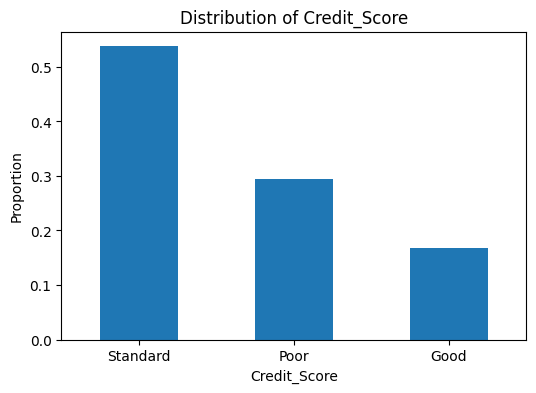

Class Proportions:
Credit_Score
Standard    0.537516
Poor        0.294906
Good        0.167578
Name: proportion, dtype: float64


In [34]:
import matplotlib.pyplot as plt

# Calculate class proportions
class_proportions = train_df['Credit_Score'].value_counts(normalize=True)

# Visualize class distribution
plt.figure(figsize=(6, 4))
class_proportions.plot(kind='bar')
plt.title('Distribution of Credit_Score')
plt.xlabel('Credit_Score')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

# Print class proportions
print("Class Proportions:")
print(class_proportions)


# Apply Encoding 

In [47]:
encoder = LabelEncoder()
scaler = StandardScaler()

In [48]:
categorical_features = ['Customer_ID','Month', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour','Credit_Score']

# Apply preprocessing to each column based on dtype
for col in train_df.columns:
    if train_df[col].dtype == 'object' and col in categorical_features:
        train_df[col] = encoder.fit_transform(train_df[[col]])
    elif train_df[col].dtype in ['int64', 'float64']:
        train_df[col] = scaler.fit_transform(train_df[[col]])



In [49]:
train_df

,Customer_ID,Month,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,11853,3,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.246223,...,1,-0.551474,-1.063676,180,0,-0.510223,-0.587316,2,-0.409719,0
1,11853,2,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.447761,...,1,-0.551474,-0.061150,180,0,-0.510223,-0.390495,3,-0.541824,0
2,11853,6,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.246223,...,1,-0.551474,-0.713983,184,0,-0.510223,-0.580641,4,-0.320989,0
3,11853,0,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.111865,...,1,-0.551474,-0.172140,185,0,-0.510223,0.031465,5,-0.831863,0
4,11853,7,-0.109351,-0.734944,-0.098379,-0.768531,-1.358012,4,128,-1.044686,...,1,-0.551474,-1.460055,186,0,-0.510223,-0.790012,1,-0.272255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,8484,0,-0.094907,-0.247284,-0.085517,0.201002,-0.899813,2,677,0.097361,...,1,-0.815185,0.470927,307,0,-0.622606,-0.688386,0,0.383779,1
99996,8484,7,-0.094907,-0.247284,-0.085517,0.201002,-0.899813,2,677,-0.238535,...,1,-0.815185,1.626057,308,0,-0.622606,-0.723656,1,0.463357,1
99997,8484,5,-0.094907,-0.247284,-0.085517,0.201002,-0.899813,2,677,0.366078,...,1,-0.815185,1.761080,309,0,-0.622606,-0.880414,0,0.558922,1
99998,8484,4,-0.094907,-0.247284,-0.085517,0.201002,-0.899813,2,677,-0.104177,...,1,-0.815185,0.270247,310,0,-0.622606,0.302875,3,-0.378093,2


# Split the dataset

In [50]:
x = train_df.drop('Credit_Score',axis = 1) #storing data to x without Credit_Score
y = train_df['Credit_Score'] # Storing only Credit_Score to y


In [51]:
xtrain,xtest,ytrain,ytest = tts(x,y,test_size = 0.2,random_state = 42)

# Applying SVM

In [ ]:
svm = SVC(kernel='linear', C=1.0)
svm.fit(xtrain,ytrain)

In [ ]:
ypred_svm = svm.predict(xtest)
print("Classification Report:\n")
print(classification_report(ytest, ypred_svm))

# Apply Logistic Regression

In [171]:
lr = LogisticRegression()
lr.fit(xtrain,ytrain)

LogisticRegression()

In [172]:
y_predLR = lr.predict(xtest)
print('Classification Report:\n\n', classification_report(ytest,y_predLR))

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3242
           1       0.57      0.37      0.45      5655
           2       0.57      0.85      0.68     10343

    accuracy                           0.57     19240
   macro avg       0.38      0.41      0.38     19240
weighted avg       0.47      0.57      0.50     19240



# Applying Random forest

In [173]:
rf = RandomForestClassifier()
rf.fit(xtrain,ytrain)

RandomForestClassifier()

In [174]:
y_predrf = rf.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predrf))

Classification Report

               precision    recall  f1-score   support

           0       0.79      0.73      0.76      3242
           1       0.78      0.84      0.81      5655
           2       0.83      0.81      0.82     10343

    accuracy                           0.81     19240
   macro avg       0.80      0.79      0.80     19240
weighted avg       0.81      0.81      0.81     19240



# Applying Balanced RandomForest Classifier

In [175]:
br = BalancedRandomForestClassifier(random_state = 42)
br.fit(xtrain,ytrain)

BalancedRandomForestClassifier(random_state=42)

In [176]:
y_predbr = br.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predbr))

Classification Report

               precision    recall  f1-score   support

           0       0.63      0.85      0.73      3242
           1       0.75      0.87      0.81      5655
           2       0.89      0.71      0.79     10343

    accuracy                           0.78     19240
   macro avg       0.76      0.81      0.77     19240
weighted avg       0.80      0.78      0.78     19240



# Applying XGBoost

In [177]:
xg = XGBClassifier(random_state = 42)
xg.fit(xtrain,ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [178]:
y_predxg = xg.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predxg))

Classification Report

               precision    recall  f1-score   support

           0       0.70      0.72      0.71      3242
           1       0.76      0.75      0.76      5655
           2       0.80      0.80      0.80     10343

    accuracy                           0.77     19240
   macro avg       0.75      0.76      0.76     19240
weighted avg       0.77      0.77      0.77     19240



# Applying AdaBoost

In [179]:
ada = AdaBoostClassifier(random_state = 42)
ada.fit(xtrain,ytrain)

AdaBoostClassifier(random_state=42)

In [180]:
y_predada = ada.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predada))

Classification Report

               precision    recall  f1-score   support

           0       0.54      0.53      0.54      3242
           1       0.67      0.59      0.62      5655
           2       0.69      0.74      0.72     10343

    accuracy                           0.66     19240
   macro avg       0.63      0.62      0.63     19240
weighted avg       0.66      0.66      0.66     19240



# Hyperparameter Optimization of Random Forest for Randomized Search

In [72]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'random_state': [42]
}

In [73]:
rf_rs = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 42), 
                            param_distributions = rf_params, n_iter = 10, cv = 5)
rf_rs.fit(x_combined, y_combined)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'random_state': [42]})

In [74]:
rf_rs.best_params_

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 30,
 'bootstrap': False}

In [75]:
y_predrf_rs = rf_rs.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predrf_rs))

Classification Report

               precision    recall  f1-score   support

           0       0.69      0.77      0.73      3242
           1       0.77      0.83      0.80      5655
           2       0.84      0.77      0.80     10343

    accuracy                           0.79     19240
   macro avg       0.77      0.79      0.78     19240
weighted avg       0.79      0.79      0.79     19240



# Hyperparameter Optimization of AdaBoost for Randomized Search

In [81]:
ada_params = {
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.0001, 0.001, 0.1, 1.0],
    'algorithm' : ['SAMME', 'SAMME.R']
}

In [82]:
Ada_Boost = AdaBoostClassifier(random_state = 42)
AdaBoost_rs = RandomizedSearchCV(estimator = Ada_Boost, param_distributions = ada_params, 
                                 n_iter = 10, cv = 5)
AdaBoost_rs.fit(xtrain,ytrain)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.0001, 0.001, 0.1,
                                                          1.0],
                                        'n_estimators': [100, 200, 300]})

In [83]:
y_predAdaBoost_rs = AdaBoost_rs.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predAdaBoost_rs))

Classification Report

               precision    recall  f1-score   support

           0       0.54      0.55      0.55      3242
           1       0.66      0.59      0.63      5655
           2       0.70      0.74      0.72     10343

    accuracy                           0.67     19240
   macro avg       0.64      0.63      0.63     19240
weighted avg       0.66      0.67      0.66     19240



# Hyperparameter Optimization of XGBoost for GRID Search

In [63]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [7,10,15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.0, 0.1, 0.2],
    'min_child_weight': [1, 2],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    }

In [ ]:
xgb_gs = GridSearchCV(XGBClassifier(random_state = 42),xgb_params, cv = 5)

xgb_gs.fit(xtrain,ytrain)

In [ ]:
y_predxgb_gs = xgb_gs.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predxgb_gs))

# Cross Validation & SMOTE (Model: Random Forest)

In [84]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sumAcc = 0
print('Accuracy:')
for train_index, test_index in k_fold.split(x,y):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    # Initialize SMOTE 
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Apply SMOTE to the training data
    xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(xtrain_resampled,ytrain_resampled)

    y_predrf = rf.predict(xtest)
    acc = accuracy_score(ytest,y_predrf)
    sumAcc +=  acc
        
    print(acc,end=' ')

print('Avg Accuracy:', sumAcc/10) 

Accuracy:
0.7939708939708939 0.7935550935550936 0.8111226611226611 0.7960498960498961 0.7951143451143451 0.7934511434511434 0.7858627858627859 0.7896049896049896 0.7931392931392931 0.7917879417879418 Avg Accuracy: 0.7943659043659045


# Cross Validation & SMOTE (Model: Balanced Random Forest)

In [85]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sumAcc = 0
print('Accuracy:')
for train_index, test_index in k_fold.split(x,y):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    # Initialize SMOTE 
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Apply SMOTE to the training data
    xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

    brf = BalancedRandomForestClassifier(random_state=42)
    brf.fit(xtrain_resampled,ytrain_resampled)

    y_predbrf = brf.predict(xtest)
    acc = accuracy_score(ytest,y_predbrf)
    sumAcc +=  acc
     
    print(acc,end=' ')

print('Avg Accuracy:', sumAcc/10)

Accuracy:
0.7943866943866944 0.7928274428274428 0.811018711018711 0.7967775467775468 0.7942827442827443 0.7920997920997921 0.7900207900207901 0.7905405405405406 0.7931392931392931 0.7890852390852391 Avg Accuracy: 0.7944178794178794


# Cross validation and SMOTE in XGBOOST

In [86]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sumAcc = 0
print('Accuracy:')
for train_index, test_index in k_fold.split(x,y):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    # Initialize SMOTE 
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Apply SMOTE to the training data
    xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

    xg = XGBClassifier(random_state = 42)
    xg.fit(xtrain_resampled,ytrain_resampled)

    y_predxg = xg.predict(xtest)
    acc = accuracy_score(ytest,y_predxg)
    sumAcc +=  acc

    print(acc,end=' ')

print('Avg Accuracy:', sumAcc/10)

Accuracy:
0.7515592515592515 0.7534303534303535 0.7688149688149688 0.756029106029106 0.7565488565488565 0.754054054054054 0.750935550935551 0.7498960498960499 0.7553014553014553 0.7521829521829522 Avg Accuracy: 0.7548752598752598


# Applying PCA

In [87]:
from sklearn.decomposition import PCA

In [88]:
# Initialize PCA with the number of components you want to keep
n_components = 15
pca = PCA(n_components=n_components)

# Fit and transform your dataset
x_pca = pca.fit_transform(x)

In [89]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sumAcc = 0
print('Accuracy:')
for train_index, test_index in k_fold.split(x_pca,y):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    # Initialize SMOTE 
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Apply SMOTE to the training data
    xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

    ada = AdaBoostClassifier(random_state = 42)
    ada.fit(xtrain_resampled, ytrain_resampled)

    y_predada = ada.predict(xtest)
    acc = accuracy_score(ytest,y_predada)
    sumAcc +=  acc

    print(acc,end=' ')

print('Avg Accuracy:', sumAcc/10)

Accuracy:
0.6502079002079002 0.653950103950104 0.6658004158004158 0.6548856548856549 0.6516632016632017 0.6583160083160083 0.6476091476091476 0.6529106029106029 0.6495841995841996 0.6648648648648648 Avg Accuracy: 0.65497920997921


In [90]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sumAcc = 0
print('Accuracy:')
for train_index, test_index in k_fold.split(x_pca,y):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    # Initialize SMOTE 
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Apply SMOTE to the training data
    xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

    brf = BalancedRandomForestClassifier(random_state=42)
    brf.fit(xtrain_resampled,ytrain_resampled)

    y_predbrf = brf.predict(xtest)
    acc = accuracy_score(ytest,y_predbrf)
    sumAcc +=  acc

    print(acc,end=' ')

print('Avg Accuracy:', sumAcc/10)

Accuracy:
0.7943866943866944 0.7928274428274428 0.811018711018711 0.7967775467775468 0.7942827442827443 0.7920997920997921 0.7900207900207901 0.7905405405405406 0.7931392931392931 0.7890852390852391 Avg Accuracy: 0.7944178794178794


# Combined Over  and Under Sampling

**WE split x,y to train & test above for this part**

In [40]:
# Step 1: Oversampling with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_oversampled, y_oversampled = smote.fit_resample(xtrain, ytrain)

# Step 2: Undersampling with Cluster Centroids
cluster_centroids = ClusterCentroids(sampling_strategy='auto', random_state=42)
x_combined, y_combined = cluster_centroids.fit_resample(x_oversampled, y_oversampled)

# using random forest and balanced random forest

In [55]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_combined, y_combined)

RandomForestClassifier(random_state=42)

In [57]:
y_predrfc = rf.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predrfc))

Classification Report

               precision    recall  f1-score   support

           0       0.69      0.78      0.73      3242
           1       0.77      0.84      0.80      5655
           2       0.85      0.77      0.81     10343

    accuracy                           0.79     19240
   macro avg       0.77      0.80      0.78     19240
weighted avg       0.80      0.79      0.79     19240



In [58]:
brfc = BalancedRandomForestClassifier(random_state=42)
brfc.fit(x_combined, y_combined)

BalancedRandomForestClassifier(random_state=42)

In [59]:
y_predbrfc = brfc.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predbrfc))

Classification Report

               precision    recall  f1-score   support

           0       0.69      0.78      0.73      3242
           1       0.77      0.84      0.80      5655
           2       0.85      0.77      0.81     10343

    accuracy                           0.79     19240
   macro avg       0.77      0.80      0.78     19240
weighted avg       0.80      0.79      0.79     19240



# Under-sampling RandomUnderSampler

In [65]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)

In [66]:
rfu = RandomForestClassifier(random_state=42)
rfu.fit(x_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [67]:
y_predrfu = rfu.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predrfu))

Classification Report

               precision    recall  f1-score   support

           0       0.63      0.85      0.72      3242
           1       0.73      0.85      0.79      5655
           2       0.87      0.70      0.78     10343

    accuracy                           0.77     19240
   macro avg       0.75      0.80      0.76     19240
weighted avg       0.79      0.77      0.77     19240



In [68]:
xgu = XGBClassifier(random_state = 42)
xgu.fit(x_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [69]:
y_predxgu = xgu.predict(xtest)

print('Classification Report\n\n', classification_report(ytest,y_predxgu))

Classification Report

               precision    recall  f1-score   support

           0       0.56      0.87      0.68      3242
           1       0.71      0.81      0.76      5655
           2       0.87      0.66      0.75     10343

    accuracy                           0.74     19240
   macro avg       0.72      0.78      0.73     19240
weighted avg       0.77      0.74      0.74     19240



# UnderSampling

In [52]:
UnderSampling = RandomUnderSampler(sampling_strategy='auto', random_state=42)
xtrain_UnderSample,ytrain_UnderSample = UnderSampling.fit_resample(xtrain,ytrain)

# Applying SVM after UnderSampling 

In [ ]:
svm = SVC(kernel='linear', C=1.0)
svm.fit(xtrain_UnderSample,ytrain_UnderSample)

In [ ]:
ypred_svm = svm.predict(xtest)
print("Classification Report:\n")
print(classification_report(ytest, ypred_svm))